In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import datetime

import statsmodels.tsa.api as smt

from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import KFold, cross_val_score, train_test_split

import pickle

In [2]:
sales_data = pd.read_csv("updated_retails_data.csv")
sales_data.shape

(9993, 11)

In [3]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9993 entries, 0 to 9992
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order ID       9993 non-null   object 
 1   Customer Name  9993 non-null   object 
 2   Category       9993 non-null   object 
 3   Sub Category   9993 non-null   object 
 4   City           9993 non-null   object 
 5   Order Date     9993 non-null   object 
 6   Region         9993 non-null   object 
 7   Sales          9993 non-null   int64  
 8   Discount       9993 non-null   float64
 9   Profit         9993 non-null   float64
 10  State          9993 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 858.9+ KB


In [4]:
sales_data.head()

,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State
0,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,2017-11-08,South,749,0.18,149.80,Tamil Nadu
1,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,2017-06-12,West,2360,0.21,165.20,Tamil Nadu
2,OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,2016-10-11,South,896,0.25,89.60,Tamil Nadu
3,OD5,Ridhesh,Food Grains,Organic Staples,Ooty,2016-10-11,South,2355,0.26,918.45,Tamil Nadu
4,OD6,Adavan,Food Grains,Organic Staples,Dharmapuri,2015-06-09,West,2305,0.26,322.70,Tamil Nadu


In [5]:

monthly_df = sales_data.copy()
monthly_df['date'] = monthly_df['Order Date'].apply(lambda x: str(x)[:-3])
monthly_df = monthly_df.groupby('date')['Sales'].sum().reset_index()
monthly_df['date'] = pd.to_datetime(monthly_df['date'])
monthly_df = monthly_df.rename(columns={'Sales': 'sales'})
monthly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    48 non-null     datetime64[ns]
 1   sales   48 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 896.0 bytes


In [6]:
monthly_df.head()

,date,sales
0,2015-01-01,122497
1,2015-02-01,66030
2,2015-03-01,247156
3,2015-04-01,203258
4,2015-05-01,164263


In [7]:
# Average monthly sales

# Overall
avg_monthly_sales = monthly_df.sales.mean()
print(f"Overall average monthly sales: {avg_monthly_sales}")

# Last 12 months (this will be the forecasted sales)
avg_monthly_sales_12month = monthly_df.sales[-12:].mean()
print(f"Last 12 months average monthly sales: {avg_monthly_sales_12month}")

Overall average monthly sales: 311577.6666666667
Last 12 months average monthly sales: 414792.6666666667


In [8]:

def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.lineplot(data=data, x=x_col, y=y_col, ax=ax, color='mediumblue', label='Total Sales')

    second = data.groupby(data[x_col].dt.year)[y_col].mean().reset_index()
    second[x_col] = pd.to_datetime(second[x_col], format='%Y')
    sns.lineplot(data=second, x=(second[x_col] + pd.DateOffset(months=6)), y=y_col, ax=ax, color='red',
                 label='Mean Sales')

    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


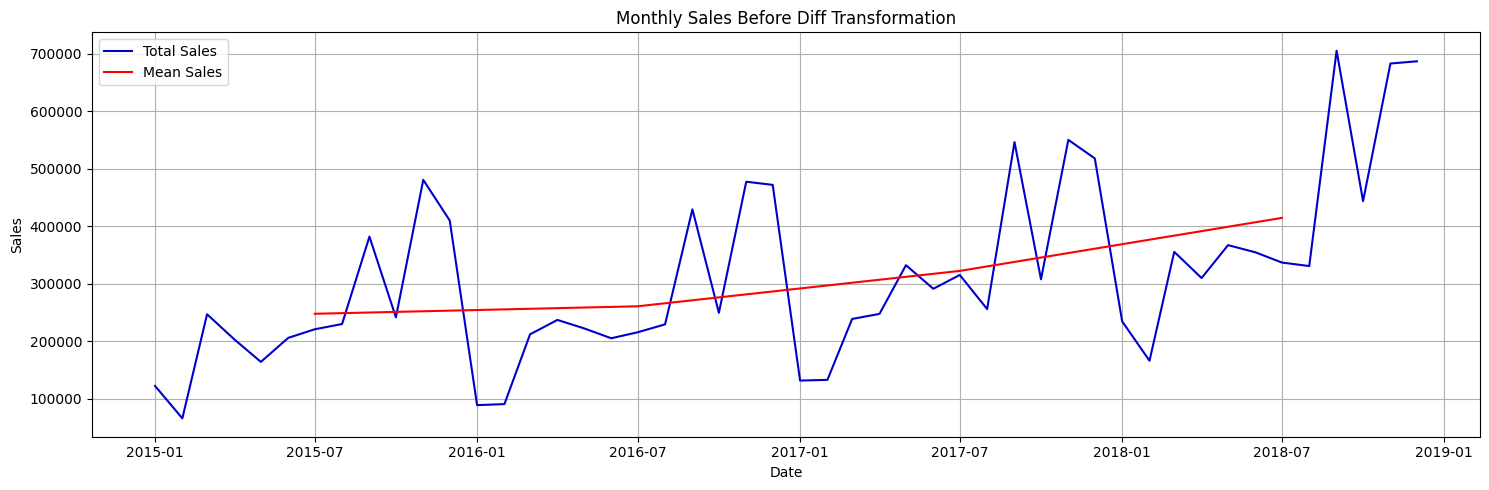

In [9]:
# time_plot(monthly_df, 'Date', 'Sales', 'Monthly Sales Before Diff Transformation')
time_plot(monthly_df, 'date', 'sales', 'Monthly Sales Before Diff Transformation')


In [10]:
# #Ho: It is non stationary
# #H1: It is stationary

# def adfuller_test(sales):
#     result=adfuller(sales)
#     labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
#     for value,label in zip(result,labels):
#         print(label+' : '+str(value) )
#     if result[1] <= 0.05:
#         print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
#     else:
#         print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
# adfuller_test(monthly_df['sales'])
    

In [11]:
def get_diff(data):
    """Returns the dataframe with a column for sales difference between each
    month. Results in a stationary time series dataframe. Prior EDA revealed
    that the monthly data was not stationary as it had a time-dependent mean.
    """
    data['sales_diff'] = data.sales.diff()
    # data['sales_diff'] = data['Sales'].diff()
    data = data.dropna()

    # data.to_csv('data/stationary_df.csv')

    return data

stationary_df = get_diff(monthly_df)
stationary_df.head()

,date,sales,sales_diff
1,2015-02-01,66030,-56467.0
2,2015-03-01,247156,181126.0
3,2015-04-01,203258,-43898.0
4,2015-05-01,164263,-38995.0
5,2015-06-01,206064,41801.0


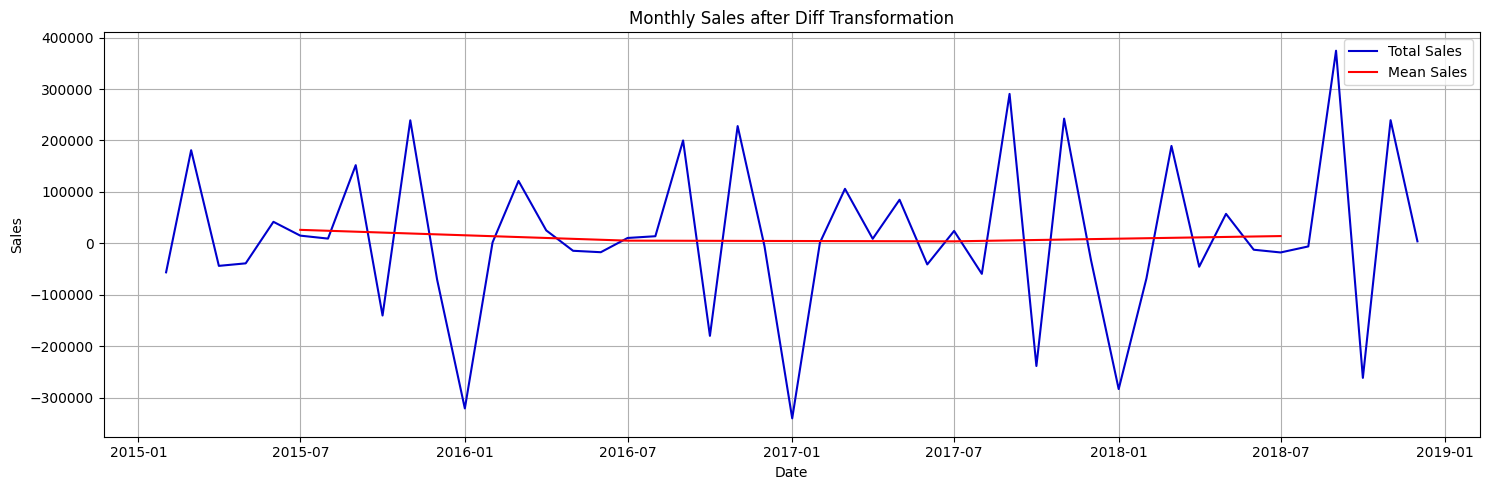

In [12]:
time_plot(stationary_df, 'date', 'sales_diff', 'Monthly Sales after Diff Transformation')


In [13]:
def generate_supervised(data):
    """Generates a csv file where each row represents a month and columns
    include sales, the dependent variable, and prior sales for each lag. Based
    on EDA, 12 lag features are generated. Data is used for regression modeling.

    Output df:
    month1  sales  lag1  lag2  lag3 ... lag11 lag12
    month2  sales  lag1  lag2  lag3 ... lag11 lag12
    """
    supervised_df = data.copy()

    #create column for each lag
    for i in range(1, 13):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['sales_diff'].shift(i)

    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)

    # supervised_df.to_csv('data/model_df.csv', index=False)
    supervised_df.head()

    return supervised_df

In [14]:
model_df = generate_supervised(stationary_df)
model_df

,date,sales,sales_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2016-02-01,90823,1814.0,-321270.0,-70700.0,239253.0,-140474.0,152039.0,9175.0,14922.0,41801.0,-38995.0,-43898.0,181126.0,-56467.0
1,2016-03-01,212164,121341.0,1814.0,-321270.0,-70700.0,239253.0,-140474.0,152039.0,9175.0,14922.0,41801.0,-38995.0,-43898.0,181126.0
2,2016-04-01,237272,25108.0,121341.0,1814.0,-321270.0,-70700.0,239253.0,-140474.0,152039.0,9175.0,14922.0,41801.0,-38995.0,-43898.0
3,2016-05-01,222722,-14550.0,25108.0,121341.0,1814.0,-321270.0,-70700.0,239253.0,-140474.0,152039.0,9175.0,14922.0,41801.0,-38995.0
4,2016-06-01,205388,-17334.0,-14550.0,25108.0,121341.0,1814.0,-321270.0,-70700.0,239253.0,-140474.0,152039.0,9175.0,14922.0,41801.0
5,2016-07-01,215776,10388.0,-17334.0,-14550.0,25108.0,121341.0,1814.0,-321270.0,-70700.0,239253.0,-140474.0,152039.0,9175.0,14922.0
6,2016-08-01,229543,13767.0,10388.0,-17334.0,-14550.0,25108.0,121341.0,1814.0,-321270.0,-70700.0,239253.0,-140474.0,152039.0,9175.0
7,2016-09-01,429658,200115.0,13767.0,10388.0,-17334.0,-14550.0,25108.0,121341.0,1814.0,-321270.0,-70700.0,239253.0,-140474.0,152039.0
8,2016-10-01,249639,-180019.0,200115.0,13767.0,10388.0,-17334.0,-14550.0,25108.0,121341.0,1814.0,-321270.0,-70700.0,239253.0,-140474.0
9,2016-11-01,477720,228081.0,-180019.0,200115.0,13767.0,10388.0,-17334.0,-14550.0,25108.0,121341.0,1814.0,-321270.0,-70700.0,239253.0


In [15]:
# ### Testing For Stationarity


# test_result=adfuller(monthly_df['sales'])
# test_result

In [16]:
# #Ho: It is non stationary
# #H1: It is stationary

# def adfuller_test(sales):
#     result=adfuller(sales)
#     labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
#     for value,label in zip(result,labels):
#         print(label+' : '+str(value) )
#     if result[1] <= 0.05:
#         print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
#     else:
#         print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
# adfuller_test(monthly_df['sales'])
    

In [17]:
# monthly_df.head()

In [18]:
def tts(data):
    data = data.drop(['sales','date'],axis=1)
    train, test = data[0:-12].values, data[-12:].values
    
    return train, test

train, test = tts(model_df)

In [19]:
train.shape

(23, 13)

In [20]:
test.shape

(12, 13)

In [21]:
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)

In [22]:
y_train.shape

(23,)

In [23]:
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

In [24]:


def predict_df(unscaled_predictions, original_df):
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-13:].date)
    act_sales = list(original_df[-13:].sales)
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    # print(df_result)
    
    return df_result

In [25]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df.sales[-12:], unscaled_df.pred_value[-12:]))
    mae = mean_absolute_error(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    r2 = r2_score(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

In [26]:

def plot_results(results, original_df, model_name):
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.lineplot(x=original_df['date'], y=original_df['sales'], ax=ax, label='Original', color='mediumblue')
    sns.lineplot(x=results['date'], y=results['pred_value'], ax=ax, label='Predicted', color='Red')

    ax.set(xlabel="Date", ylabel="Sales", title=f"{model_name} Sales Forecasting Prediction")
    ax.legend()
    sns.despine()


In [27]:
def regressive_model(train_data, test_data, model, model_name):
    """Runs regressive models in SKlearn framework. First calls scale_data
    to split into X and y and scale the data. Then fits and predicts. Finally,
    predictions are unscaled, scores are printed, and results are plotted and
    saved.

    Keyword arguments:
    -- train_set: dataset used to train the model
    -- test_set: dataset used to test the model
    -- model: the sklearn model and model arguments in the form of
              model(kwarga)
    -- model_name: the name that will be used to store model scores and plotting
    """

    # Split into X & y and scale data
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data,
                                                                 test_data)
    # Run sklearn models
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)

    # Undo scaling to compare predictions against original data
    original_df = monthly_df
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, original_df)

    # print scores and plot results
    get_scores(unscaled_df, original_df, model_name)
    plot_results(unscaled_df, original_df, model_name)

    

RMSE: 67248.08499627827
MAE: 62096.333333333336
R2 Score: 0.8489889473868947


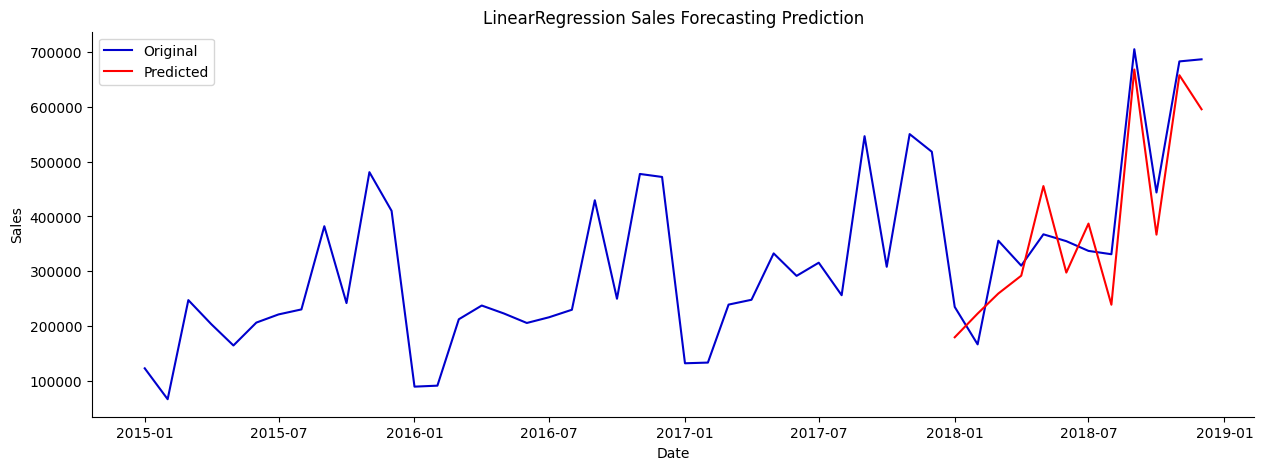

In [28]:
regressive_model(train, test, LinearRegression(), 'LinearRegression')